In [65]:
from gensim.models import Word2Vec
import os
import json
import datetime
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

In [66]:
DATA = "../data/data"

In [67]:
total_playlists = 0
total_tracks = 0
uri_to_track = {}
tokens = []
tracks = set()
artists = set()
albums = set()
titles = set()
total_descriptions = 0
ntitles = set()

In [98]:
def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            mpd_slice = json.loads(js)
            for playlist in mpd_slice["playlists"]:
                process_playlist(playlist)
            count += 1

def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

def to_date(epoch):
    return datetime.datetime.fromtimestamp(epoch).strftime("%Y-%m-%d")

def process_playlist(playlist):
    global total_playlists, total_tracks, tokens

    total_playlists += 1

    titles.add(playlist["name"])
    nname = normalize_name(playlist["name"])
    ntitles.add(nname)

    tracks = playlist["tracks"]
    total_tracks += len(tracks)
    # curr_tokens = [track["track_uri"] for track in tracks]
    curr_tokens = []
    for track in tracks:
        name = track["track_uri"]
        artist = track["artist_uri"]
        album = track["album_uri"]

        uri_to_track[name] = track
        uri_to_track[artist] = track
        uri_to_track[album] = track

        curr_tokens.append((name, artist, album))

    tokens.append(curr_tokens)

In [99]:
process_mpd(DATA)

In [100]:
def plot_histogram(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

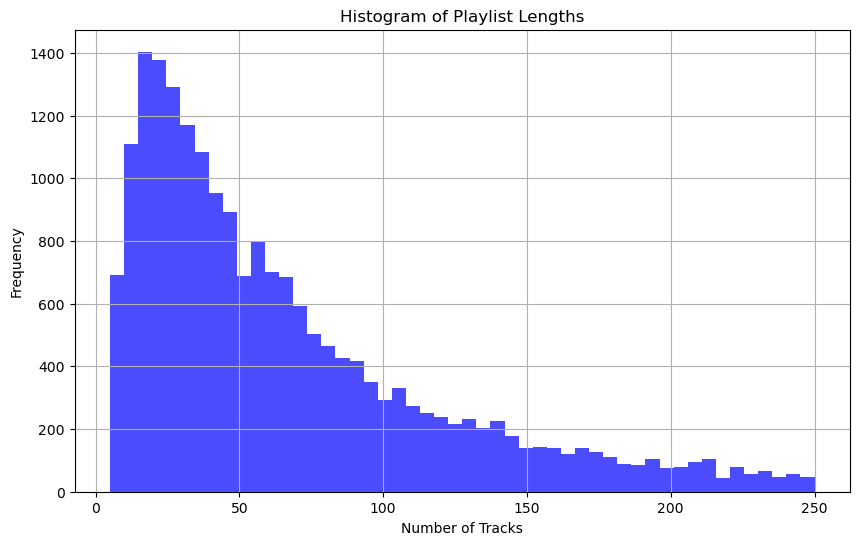

In [101]:
# plot histogram of length of tokens
plot_histogram(
    [len(t) for t in tokens],
    "Histogram of Playlist Lengths",
    "Number of Tracks",
    "Frequency"
)

In [102]:
from collections import Counter

def filter_rare_tokens(playlists, min_count=10):
    # 1) Figure out how many elements per tuple
    if not playlists or not playlists[0]:
        return []

    tuple_len = len(playlists[0][0])

    # 2) Build one Counter per tuple index
    counters = [Counter() for _ in range(tuple_len)]
    for pl in playlists:
        for tup in pl:
            for i, val in enumerate(tup):
                counters[i][val] += 1

    # 3) Filter each playlist
    filtered_playlists = []
    for pl in playlists:
        new_pl = []
        for tup in pl:
            # only keep if every element in the tuple is frequent enough
            if all(counters[i][tup[i]] >= min_count for i in range(tuple_len)):
                new_pl.append(tup)
        # keep playlists that still have at least 2 tuples
        if len(new_pl) >= 2:
            filtered_playlists.append(new_pl)

    return filtered_playlists


In [103]:
filtered_tokens = filter_rare_tokens(tokens, min_count=5)
flat_playlists = [
    [t for (track_uri, artist_uri, album_uri) in pl
       for t in (track_uri, artist_uri, album_uri)]
    for pl in tokens
]

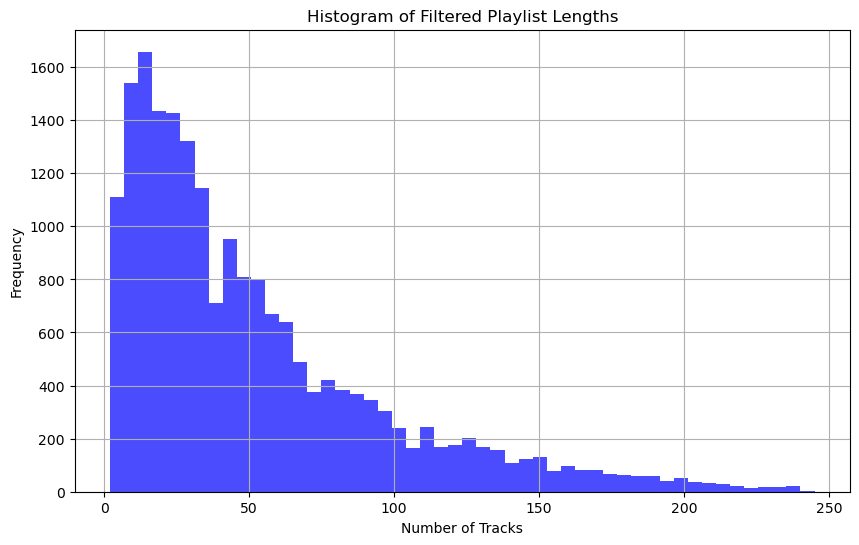

In [104]:
plot_histogram(
    [len(t) for t in filtered_tokens],
    "Histogram of Filtered Playlist Lengths",
    "Number of Tracks",
    "Frequency"
)

In [105]:
# model = Word2Vec(
#     sentences=filtered_tokens,
#     vector_size=128,
#     window=5,
#     min_count=10,
#     workers=4,
#     epochs=10,
#     sg=1  # skip-gram
# )
model = Word2Vec(
    vector_size=128, window=5, min_count=10,
    sg=1, hs=0, negative=10, sample=1e-4,
    alpha=0.025, min_alpha=0.0001,
    workers=4
)
model.build_vocab(flat_playlists)
print("Vocabulary size:", len(model.wv))
model.train(
    filtered_tokens,
    total_examples=model.corpus_count,
    epochs=10,
    compute_loss=True
)


Vocabulary size: 50940


(0, 10184640)

In [106]:
# model.save("word2vec.model")

In [107]:
for wv in model.wv.index_to_key[:10]:
    track = uri_to_track.get(wv, None)
    track_name = track["track_name"] if track else "Unknown Track"
    track_artist = track["artist_name"] if track else "Unknown Artist"
    track_album = track["album_name"] if track else "Unknown Album"

    for curr in model.wv.most_similar(wv, topn=10):
        curr_track = uri_to_track.get(curr[0], None)
        curr_name = curr_track["track_name"] if curr_track else "Unknown Track"
        curr_artist = curr_track["artist_name"] if curr_track else "Unknown Artist"
        curr_album = curr_track["album_name"] if curr_track else "Unknown Album"

        print(f"{track_name} by {track_artist} ({track_album}) "
              f"similar to {curr_name} by {curr_artist} ({curr_album}) "
              f"with similarity {curr[1]:.4f}")

Passionfruit by Drake (More Life) similar to I Never Know by Generationals (Heza) with similarity 0.3864
Passionfruit by Drake (More Life) similar to Closer by Goapele (Change It All) with similarity 0.3657
Passionfruit by Drake (More Life) similar to Unbelievable by Diamond Rio (16 Biggest Hits) with similarity 0.3598
Passionfruit by Drake (More Life) similar to Wagon Wheel by Darius Rucker (True Believers) with similarity 0.3360
Passionfruit by Drake (More Life) similar to Men In Black by Will Smith (Big Willie Style) with similarity 0.3322
Passionfruit by Drake (More Life) similar to My Friend by DnH Drop'n Harmony (Dnh the Ballad Collection) with similarity 0.3302
Passionfruit by Drake (More Life) similar to You by Jesse Powell (Jesse Powell) with similarity 0.3257
Passionfruit by Drake (More Life) similar to The Medic by Foxing (The Albatross) with similarity 0.3181
Passionfruit by Drake (More Life) similar to Let Me Know by Verse Simmonds (To All The Girls) with similarity 0.3167

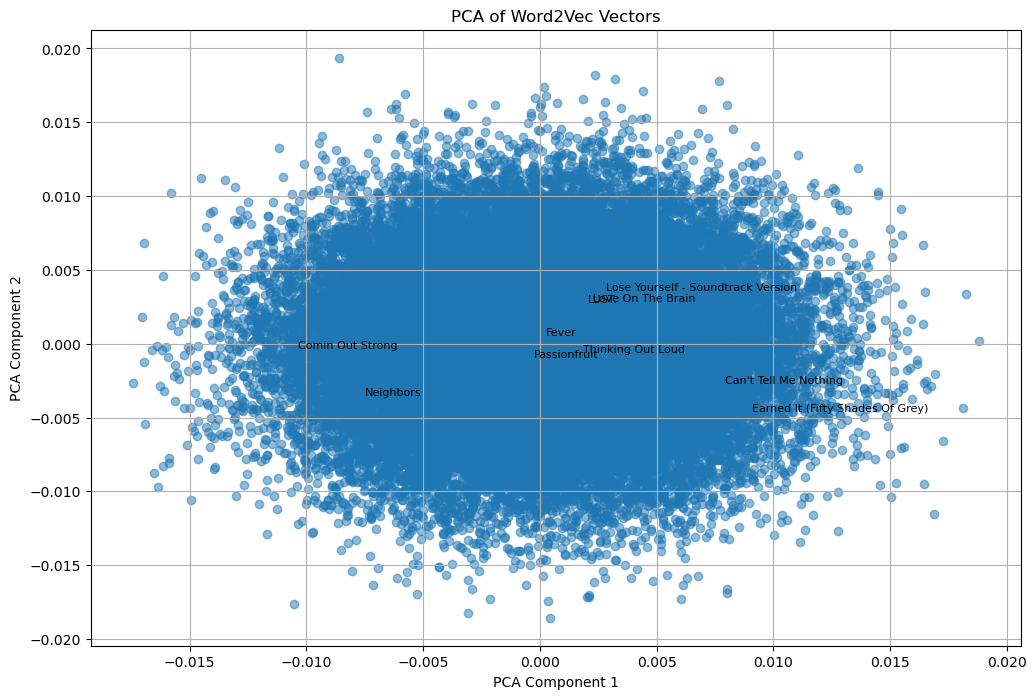

In [108]:
# PCA analysis of vectors

def plot_pca(model):
    pca = PCA(n_components=2)
    vectors = model.wv.vectors
    reduced_vectors = pca.fit_transform(vectors)

    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5)

    for i, word in enumerate(model.wv.index_to_key[:10]):  # limit to first 100 words for clarity
        track_name = uri_to_track.get(word, {}).get("track_name", "Unknown Track")
        plt.annotate(track_name, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)

    plt.title("PCA of Word2Vec Vectors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

plot_pca(model)

In [109]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, perplexity=30)
# vectors = model.wv.vectors
# coords = tsne.fit_transform(vectors)

# plt.figure(figsize=(12, 8))
# plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
# for i, word in enumerate(model.wv.index_to_key[:10]):  # limit to first 100 words for clarity
#     track_name = uri_to_track.get(word, {}).get("track_name", "Unknown Track")
#     plt.annotate(track_name, (coords[i, 0], coords[i, 1]), fontsize=8)
# plt.title("t-SNE of Word2Vec Vectors")

In [110]:
from sklearn.metrics.pairwise import cosine_similarity

def recall_at_k(model, playlists, k=10):
    wv = model.wv
    hits = 0
    for pl in playlists:
        if len(pl) < 2:
            continue

        context, target = pl[:-1], pl[-1]
        # avg context vector
        ctx_vec = sum(wv[t] for t in context if t in wv) / len(context)
        sims = cosine_similarity([ctx_vec], wv.vectors)[0]
        topk = sims.argsort()[-k:]
        if wv.key_to_index.get(target, -1) in topk:
            hits += 1
    return hits / len(playlists)


In [111]:
# recall_at_k(model, filtered_tokens, k=10)

In [112]:
# recall_at_k(model, filtered_tokens, k=100)

In [113]:
from sklearn.metrics.pairwise import cosine_similarity

def mean_reciprocal_rank(model, playlists, uri_to_track=None):
    wv = model.wv
    total_mrr = 0.0
    valid = 0

    for pl in playlists:
        # must have at least one context token + one target
        if len(pl) < 2:
            continue

        context, target = pl[:-1], pl[-1]
        # skip if target not seen
        if target not in wv:
            if uri_to_track:
                name = uri_to_track.get(target, {}).get('track_name', 'Unknown')
                print(f"{name} not in vocabulary")
            continue

        # gather only in-vocab context vectors
        vecs = [wv[t] for t in context if t in wv]
        if not vecs:
            # no valid context
            continue

        # compute avg context vector
        ctx_vec = sum(vecs) / len(vecs)

        # compute similarities
        sims = cosine_similarity([ctx_vec], wv.vectors)[0]
        target_idx = wv.key_to_index[target]

        # find rank (1-based)
        ranked = sims.argsort()[::-1]
        position = (ranked == target_idx).nonzero()[0]
        if position.size == 0:
            # shouldn’t happen, but guard just in case
            continue

        rank = position[0] + 1
        total_mrr += 1.0 / rank
        valid += 1

    return (total_mrr / valid) if valid > 0 else 0.0

In [114]:
mean_reciprocal_rank(model, filtered_tokens)

0.0